Running relu+cross_entropy
Acc: 93.82571428571428
Running relu+mse
Acc: 84.30428571428571
Running sigmoid+cross_entropy
Acc: 90.64
Running sigmoid+mse
Acc: 86.23428571428572
Running tanh+cross_entropy
Acc: 93.51
Running tanh+mse
Acc: 92.56571428571428


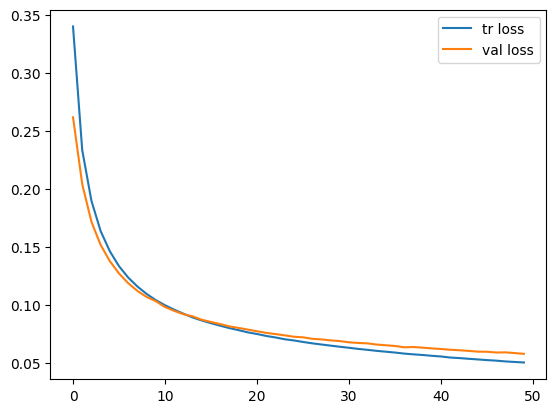

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import warnings
import csv

warnings.filterwarnings('ignore')



class NN:
    def __init__(self, ls, act='relu', loss_fn='cross_entropy', lr=0.01):
        self.ls = ls
        self.nl = len(ls)
        self.lr = lr
        self.loss_fn = loss_fn

        if act == 'sigmoid':
            self.act = self._sig; self.act_d = self._sig_d
        elif act == 'tanh':
            self.act = self._tanh; self.act_d = self._tanh_d
        elif act == 'relu':
            self.act = self._relu; self.act_d = self._relu_d
        else:
            raise ValueError("bad act")

        self.W = {}
        self.b = {}
        self._init()

        self.cache = {}
        self.train_ls = []
        self.train_acc = []
        self.val_ls = []
        self.val_acc = []

        rsss = 42

    def _init(self):
        for i in range(1, self.nl):
            if self.act == self._relu:
                self.W[f'{i}'] = np.random.randn(self.ls[i], self.ls[i-1]) * np.sqrt(2/self.ls[i-1])
            else:
                self.W[f'{i}'] = np.random.randn(self.ls[i], self.ls[i-1]) * np.sqrt(1/self.ls[i-1])
            self.b[f'{i}'] = np.zeros((self.ls[i], 1))

    def _sig(self, z):
        z = np.clip(z, -500, 500)
        return 1/(1+np.exp(-z))

    def _sig_d(self, z):
        s = self._sig(z)
        return s*(1-s)

    def _tanh(self, z):
        return np.tanh(z)

    def _tanh_d(self, z):
        return 1 - np.tanh(z)**2

    def _relu(self, z):
        return np.maximum(0, z)

    def _relu_d(self, z):
        return (z > 0).astype(float)

    def _soft(self, z):
        ez = np.exp(z - np.max(z, axis=0, keepdims=True))
        return ez/np.sum(ez, axis=0, keepdims=True)

    def fwd(self, X):
        self.cache['A0'] = X
        for i in range(1, self.nl):
            Z = self.W[f'{i}'] @ self.cache[f'A{i-1}'] + self.b[f'{i}']
            self.cache[f'Z{i}'] = Z
            if i == self.nl-1:
                A = self._soft(Z)
            else:
                A = self.act(Z)
            self.cache[f'A{i}'] = A
        return self.cache[f'A{self.nl-1}']

    def loss(self, Yt, Yp):
        m = Yt.shape[1]
        if self.loss_fn == 'cross_entropy':
            yp = np.clip(Yp, 1e-12, 1-1e-12)
            return -np.sum(Yt*np.log(yp))/m
        elif self.loss_fn == 'mse':
            return np.sum((Yt-Yp)**2)/(2*m)
        else:
            raise ValueError("bad loss")

    def bwd(self, Yt):
        m = Yt.shape[1]
        grads = {}
        if self.loss_fn == 'cross_entropy':
            dZ = self.cache[f'A{self.nl-1}'] - Yt
        else:
            dA = self.cache[f'A{self.nl-1}'] - Yt
            dZ = dA * self.act_d(self.cache[f'Z{self.nl-1}'])
        for i in range(self.nl-1, 0, -1):
            grads[f'dW{i}'] = dZ @ self.cache[f'A{i-1}'].T / m
            grads[f'db{i}'] = np.sum(dZ, axis=1, keepdims=True)/m
            if i > 1:
                dA_prev = self.W[f'{i}'].T @ dZ
                dZ = dA_prev * self.act_d(self.cache[f'Z{i-1}'])
        return grads

    def upd(self, grads):
        for i in range(1, self.nl):
            self.W[f'{i}'] -= self.lr * grads[f'dW{i}']
            self.b[f'{i}'] -= self.lr * grads[f'db{i}']

    def pred(self, X):
        p = self.fwd(X)
        return np.argmax(p, axis=0), p

    def acc(self, Yt, Yp):
        return np.mean(np.argmax(Yp, axis=0)==np.argmax(Yt, axis=0))*100

    def train(self, Xt, Yt, Xv=None, Yv=None, ep=100, bs=32, verbose=True):
        m = Xt.shape[1]
        for e in range(ep):
            perm = np.random.permutation(m)
            Xs, Ys = Xt[:,perm], Yt[:,perm]
            lsum, asum = 0, 0
            for b in range(m//bs):
                st, en = b*bs, b*bs+bs
                Xb, Yb = Xs[:,st:en], Ys[:,st:en]
                Yp = self.fwd(Xb)
                l = self.loss(Yb, Yp); a = self.acc(Yb, Yp)
                lsum += l; asum += a
                g = self.bwd(Yb); self.upd(g)
            tl = lsum/(m//bs); ta = asum/(m//bs)
            self.train_ls.append(tl); self.train_acc.append(ta)
            if Xv is not None:
                Ypv = self.fwd(Xv); vl = self.loss(Yv, Ypv); va = self.acc(Yv, Ypv)
                self.val_ls.append(vl); self.val_acc.append(va)
            if verbose and e%10==0:
                print(f"Ep {e}: tr_ls={tl:.3f}, tr_acc={ta:.1f}%, "
                      + (f"v_ls={vl:.3f}, v_acc={va:.1f}%" if Xv is not None else ""))

    def debug_loss_plot(self):
        plt.plot(self.train_ls, label='tr loss')
        if self.val_ls: plt.plot(self.val_ls, label='val loss')
        plt.legend(); plt.show()


def ld():
    mn = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    X, y = mn.data.astype(np.float32)/255.0, mn.target.astype(int)
    return X.T, y

def tst(a):
    return None

def oh(y, nc=10):
    oh = np.eye(nc)[y]
    return oh.T

def vis(X, y, n=10):
    fig, ax = plt.subplots(2,5, figsize=(8,4))
    ax = ax.ravel()
    for i in range(n):
        ax[i].imshow(X[:,i].reshape(28,28), cmap='gray')
        ax[i].set_title(y[i]); ax[i].axis('off')
    plt.show()

def main():
    X, y = ld()
    Y = oh(y)
    Xtr, Ytr = X[:,:10000], Y[:,:10000]
    Xv, Yv = X[:,10000:12000], Y[:,10000:12000]
    combos = [
        ('relu','cross_entropy'),
        ('relu','mse'),
        ('sigmoid','cross_entropy'),
        ('sigmoid','mse'),
        ('tanh','cross_entropy'),
        ('tanh','mse'),
    ]
    for act, lf in combos:
        print(f"Running {act}+{lf}")
        m = NN([784,64,10], act=act, loss_fn=lf, lr=0.05)
        m.train(Xtr, Ytr, Xv, Yv, ep=50, bs=128, verbose=False)
        preds, _ = m.pred(X)
        print("Acc:", np.mean(preds==y)*100)
        with open('results.csv','a',newline='') as f:
            writer = csv.writer(f)
            writer.writerow([act, lf, np.mean(preds==y)*100])
    m.debug_loss_plot()


if __name__ == "__main__":
    main()
